<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Inititial-Record-Ingestion" data-toc-modified-id="Inititial-Record-Ingestion-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Inititial Record Ingestion</a></span><ul class="toc-item"><li><span><a href="#Connect-To-And-Re-Create-DB" data-toc-modified-id="Connect-To-And-Re-Create-DB-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Connect To And Re-Create DB</a></span></li><li><span><a href="#Read-And-(Re-)Format-Existing-Collection-File" data-toc-modified-id="Read-And-(Re-)Format-Existing-Collection-File-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Read And (Re-)Format Existing Collection File</a></span></li><li><span><a href="#Write-Records-To-DB" data-toc-modified-id="Write-Records-To-DB-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Write Records To DB</a></span></li><li><span><a href="#Check-The-Results" data-toc-modified-id="Check-The-Results-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Check The Results</a></span></li></ul></li><li><span><a href="#Initial-Credit-Addition" data-toc-modified-id="Initial-Credit-Addition-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Initial Credit Addition</a></span></li></ul></div>

In [1]:
import configparser
import datetime as dt
import sys
import collections
from pathlib import Path
from typing import Union, Optional, List, Tuple

import codebook.EDA as EDA
import codebook.clean as clean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
from sqlalchemy import func

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.style.use('raph-base')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', 30)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 800)

np.random.seed(666)

In [3]:
Path.cwd().parent / 'src'

WindowsPath('C:/Users/r2d4/OneDrive/code/projects/20-02_disco/src')

In [4]:
sys.path.append(str(Path.cwd().parent))

from src.db_declaration import Base, Artist, CreditTrx, Genre, Label, Record
from src import db_functions
from src import utils

<class 'sqlalchemy.ext.declarative.api.DeclarativeMeta'>


In [5]:
print(sys.executable)
print(sys.version)
print(f'sqlalchemy {sqlalchemy.__version__}')

C:\Users\r2d4\miniconda3\envs\py3\python.exe
3.8.3 (default, May 19 2020, 06:50:17) [MSC v.1916 64 bit (AMD64)]
sqlalchemy 1.3.17


## Inititial Record Ingestion

In [6]:
CONFIG_PATH = Path.cwd().parent / "config.cfg"

### Connect To And Re-Create DB

<div class="alert alert-block alert-danger">
Attention This Will Delete All Entries In The DB!
</div>

In [7]:
path_to_prod_db = r"C:\Users\r2d4\OneDrive\code\projects\20-02_disco\db_aka_discobase\DiscoBase.db"
engine = utils.create_engine(path_to_prod_db)
session = utils.create_session(engine)
utils.create_DB_anew(engine, Base)

C:\Users\r2d4\OneDrive\code\projects\20-02_disco\db_aka_discobase\DiscoBase.db


### Read And (Re-)Format Existing Collection File

In [8]:
def load_albums_from_xlsx(
    filepath: Union[Path, str], genres: Optional[List] = None
) -> pd.DataFrame:
    """Load the original album collection file into a dataframe.
    You can specify a list of genres you want to include
    (defaults to None).
    """
    df = pd.read_excel(filepath, engine="openpyxl")
    if genres:
        df = df[df["Genre"].isin(genres)]
    return df

In [9]:
path_to_collection = utils.read_config_return_str(CONFIG_PATH, "COLLECTION")
collection_df = load_albums_from_xlsx(path_to_collection)
collection_df = clean.prettify_column_names(collection_df)
collection_df.dropna(thresh=8, inplace=True)
collection_df.rename(columns={"format": "record_format"}, inplace=True)
# collection_df["purchase_date"] = collection_df["purchase_date"].dt.date.astype(str)
# collection_df["number"] = collection_df["number"].astype(str)
# collection_df["digitized"] = collection_df["digitized"].map({True: 1, False: 0}).astype(int)
collection_df["label"].fillna("NA", inplace=True)  # because it creates a foreign key

# This is for the initial ingestion only
collection_df["artist_country"] = None
collection_df["credit_value"] = 0
collection_df["trx_type"] = "Initial Load"

In [10]:
collection_df.shape
collection_df.info()

(293, 18)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293 entries, 0 to 292
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   active          293 non-null    float64       
 1   artist          293 non-null    object        
 2   title           293 non-null    object        
 3   record_format   293 non-null    object        
 4   year            293 non-null    float64       
 5   genre           293 non-null    object        
 6   price           293 non-null    float64       
 7   purchase_date   293 non-null    datetime64[ns]
 8   vinyl_color     197 non-null    object        
 9   lim_edition     207 non-null    object        
 10  number          24 non-null     object        
 11  label           293 non-null    object        
 12  digitized       293 non-null    object        
 13  remarks         72 non-null     object        
 14  rating          101 non-null    float64       
 15  artist

In [11]:
EDA.display_nan(collection_df)

,total,prop,dtype
artist_country,293,100.0%,object
number,269,91.8%,object
remarks,221,75.4%,object
rating,192,65.5%,float64
vinyl_color,96,32.8%,object
lim_edition,86,29.4%,object


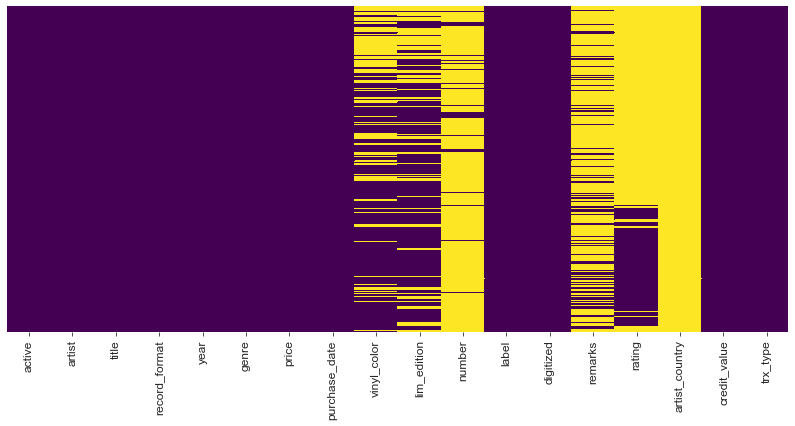

In [12]:
EDA.plot_nan(collection_df)

### Write Records To DB

**TODO:** Can I apply()?

In [13]:
def insert_df_with_sqlalchemy_orm(session, df):
    for x in df.to_dict("records"):
        db_functions.add_new_record(session, x)

In [14]:
insert_df_with_sqlalchemy_orm(session, collection_df)

C:\Users\r2d4\miniconda3\envs\py3\lib\site-packages\sqlalchemy\sql\sqltypes.py:660: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors and other issues may occur. Please consider storing Decimal numbers as strings or integers on this platform for lossless storage.
  util.warn(


### Check The Results

In [15]:
# Total Number Of Records In The DB
session.query(Record).count()

293

In [16]:
session.query(Artist).count()
session.query(Artist).all()[-5:]

188

[<Artist(artist_id=184, artist_name=Disembowel)>,
 <Artist(artist_id=185, artist_name=Mortal Wound / Gutless)>,
 <Artist(artist_id=186, artist_name=End)>,
 <Artist(artist_id=187, artist_name=Organic)>,
 <Artist(artist_id=188, artist_name=Ironed Out)>]

In [17]:
session.query(Genre).count()
session.query(Genre).all()

9

[<Genre(genre_id=1, genre_name=Death Metal)>,
 <Genre(genre_id=2, genre_name=Thrash Metal)>,
 <Genre(genre_id=3, genre_name=Black Metal)>,
 <Genre(genre_id=4, genre_name=Speed Metal)>,
 <Genre(genre_id=5, genre_name=Hardcore)>,
 <Genre(genre_id=6, genre_name=Punk)>,
 <Genre(genre_id=7, genre_name=Crust)>,
 <Genre(genre_id=8, genre_name=Crossover)>,
 <Genre(genre_id=9, genre_name=Grindcore)>]

In [18]:
session.query(func.sum(CreditTrx.credit_value)).all()[0][0]
session.query(func.min(CreditTrx.credit_value)).all()[0][0]
session.query(func.avg(CreditTrx.credit_value)).all()[0][0]

0.0

0.0

0.0

## Initial Credit Addition

In [37]:
to_delete = session.query(CreditTrx).filter(CreditTrx.credit_trx_id == 297).one()
session.delete(to_delete)

In [21]:
# Add initial Addition trx, check the date an credit_saldo

fake_trx = CreditTrx(
    credit_trx_date=dt.datetime(year=2020, month=12, day=30),
    credit_trx_type="Addition",
    credit_value=1,
    credit_saldo=-1,
    record_id=np.nan
)
session.add(fake_trx)

In [38]:
# Check
session.commit()
session.query(CreditTrx).all()[-3:]

[<CreditTrx(credit_trx_id=294, credit_trx_date=2020-12-12, credit_trx_type=Purchase, credit_value=0.0, credit_saldo=0.0, record_id=294)>,
 <CreditTrx(credit_trx_id=295, credit_trx_date=2020-12-30, credit_trx_type=Addition, credit_value=1.0, credit_saldo=-1.0, record_id=None)>,
 <CreditTrx(credit_trx_id=296, credit_trx_date=2021-01-07, credit_trx_type=Purchase, credit_value=-1.0, credit_saldo=-2.0, record_id=295)>]

In [44]:
db_functions.add_regular_credits(session)

2020-12-30


In [45]:
session.query(CreditTrx).all()[-3:]

[<CreditTrx(credit_trx_id=295, credit_trx_date=2020-12-30, credit_trx_type=Addition, credit_value=1.0, credit_saldo=-1.0, record_id=None)>,
 <CreditTrx(credit_trx_id=296, credit_trx_date=2021-01-07, credit_trx_type=Purchase, credit_value=-1.0, credit_saldo=-2.0, record_id=295)>,
 <CreditTrx(credit_trx_id=297, credit_trx_date=2021-01-09, credit_trx_type=Addition, credit_value=1.0, credit_saldo=-1.0, record_id=None)>]

In [43]:
# session.rollback()

In [46]:
session.close()